## This notebook contains exploratory data analysis of data used for training.  

In [1]:
import os
import json
import random

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from task2.utils.paths import NER_DATA_PATH
from task2.utils.data_loader import load_ner_dataset

## Computer Vision Animals-10 dataset

##### For the Computer Vision part of the task I have chosen the `Animals-10` dataset by `alessiocorrado99` from Kaggle. 
 
One can download it from `Kaggle` or use a local version.

In [2]:
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")

100%|██████████| 586M/586M [00:55<00:00, 11.0MB/s] 

Extracting files...


In [3]:
root = os.path.join(path, 'raw-img') # kaggle
# root = '../task2/data/animals10/raw-img' # locally

##### Load animal images into a dataframe.

For simplicity I am only using first 100 images for each class, as it is enough for exploratory analysis.  
The full dataset is imbalanced, so I used first 1000 images when training. I also trained a model on 1400 images per class on a PC, but it did not improve the performance, so I think 1000 in enough. Another approach would be to load everything and use an Under Sampler. Unfortunately my current setup (my favourite comfortable the most beautiful laptop that became my dearest friend) lacks computational power for CV tasks like this as it does not have GPUs. 

In [20]:
img_paths = []
labels = []

# for each animal (separate folder for each)
for animal in os.listdir(root):
    # join the animal folder to path
    path = os.path.join(root, animal)
    # use first 100 images to make sure the dataset is balanced
    for img in os.listdir(path)[:100]:
        # add image path
        img_paths.append(os.path.join(path, img))
        # add label (animal name)
        labels.append(animal)

In [21]:
df = pd.DataFrame({
    'img_path' : img_paths,
    'label' : labels
})
df.head(10)

,img_path,label
0,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
1,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
2,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
3,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
4,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
5,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
6,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
7,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
8,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane
9,C:\Users\sofee\.cache\kagglehub\datasets\aless...,cane


##### Translate the labels

Since the original dataset is in Italian, here is a way to translate the labels to English, as well as convert index to label and back.

In [22]:
label = {"cane": "dog",
         "cavallo": "horse",
         "elefante": "elephant",
         "farfalla": "butterfly",
         "gallina": "chicken",
         "gatto": "cat",
         "mucca": "cow",
         "pecora": "sheep",
         "ragno" : "spider",
         "scoiattolo": "squirrel"}

label_to_index = {key: idx for idx, key in enumerate(label.keys())}
index_to_label = {idx: value for key, value in label.items() for idx, k in enumerate(label.keys()) if k == key}

In [23]:
df['label_num'] = df['label'].map(label_to_index)
df['label'] = df['label'].map(label)
df.head(10)

,img_path,label,label_num
0,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
1,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
2,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
3,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
4,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
5,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
6,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
7,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
8,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0
9,C:\Users\sofee\.cache\kagglehub\datasets\aless...,dog,0


##### I make sure the data is balanced

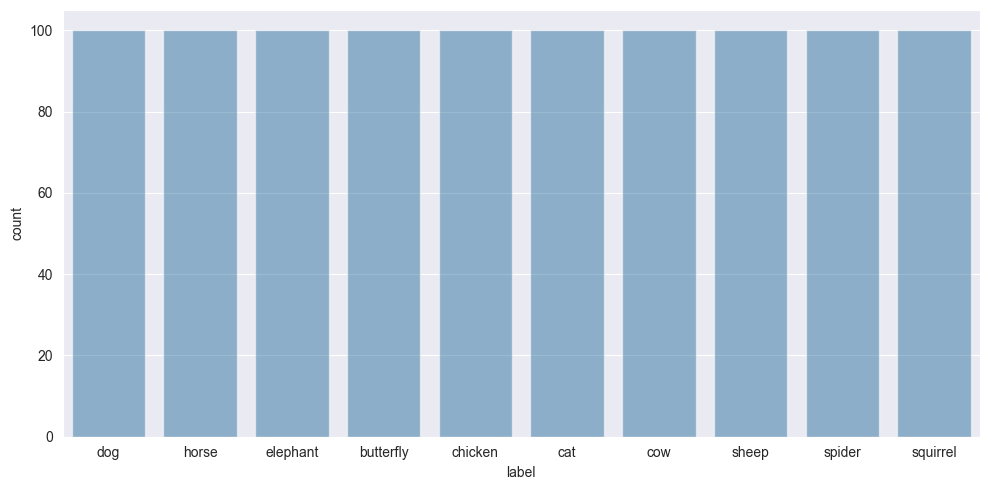

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(df, x='label', alpha = 0.5)
plt.tight_layout()

In [25]:
df.value_counts('label')

label
butterfly    100
cat          100
chicken      100
cow          100
dog          100
elephant     100
horse        100
sheep        100
spider       100
squirrel     100
Name: count, dtype: int64

##### Let's take a look at a few random pictures.

In [26]:
random_pictures = random.sample(range(len(df)), 12)

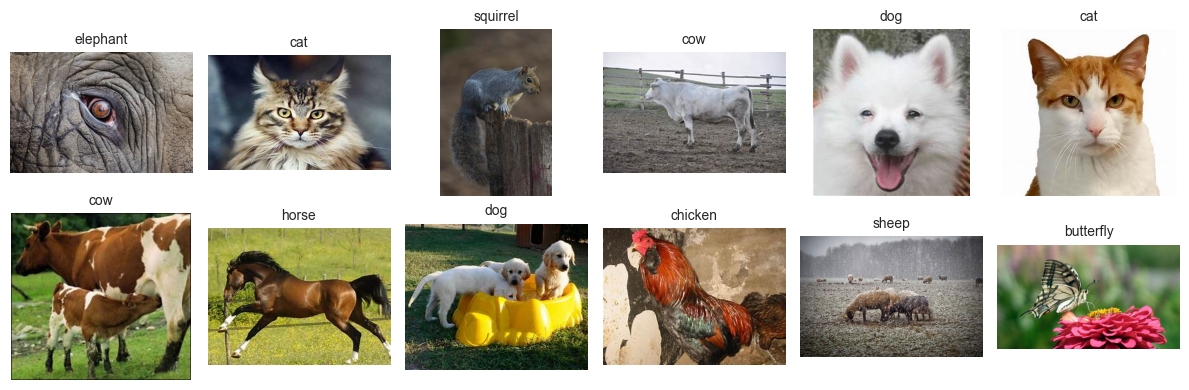

In [27]:
fig, ax = plt.subplots(2, 6, figsize=(12, 4))
ax = ax.flatten()

for i, idx in enumerate(random_pictures):
    image = plt.imread(df['img_path'].iloc[idx])
    ax[i].imshow(image)
    ax[i].set_title(df['label'].iloc[idx], fontsize = 10)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

##### As we may see, there are many different pictures all in different sizes. Let's preprocess them.

In [28]:
all_images = []

def preprocess_image(image_path, size=(224, 224)):
    # read an image
    image = cv2.imread(image_path)
    # cv2 reads image in BGR so convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize to make sure dimensions are the same for all the pictures
    image = cv2.resize(image, size)
    return image

for i in df['img_path'].values:
    image = preprocess_image(i)
    all_images.append(image)

##### All images are square now

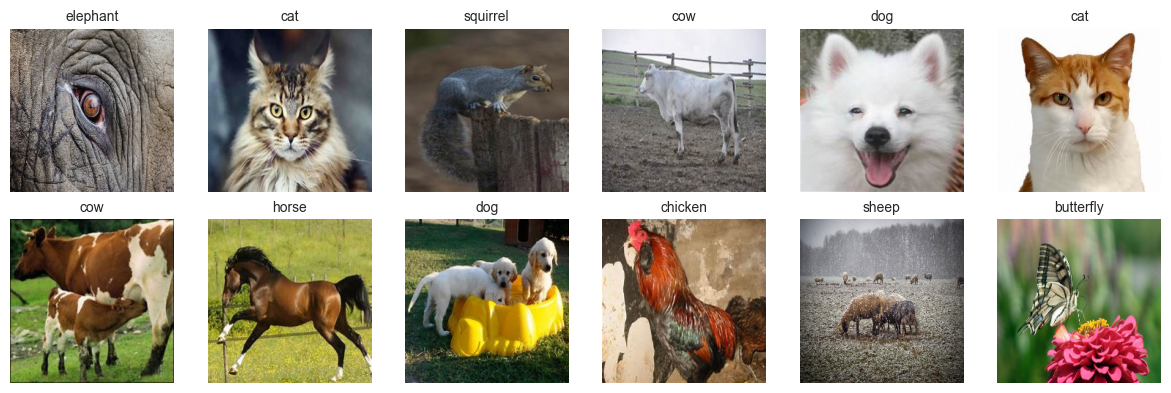

In [29]:
fig, ax = plt.subplots(2, 6, figsize=(12, 4))
ax = ax.flatten()

for i, idx in enumerate(random_pictures):
    image = all_images[idx]
    ax[i].imshow(image)
    ax[i].set_title(df['label'].iloc[idx], fontsize=10)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [30]:
all_images = np.array(all_images)

##### Split the data 80 / 10 / 10 | train / validation / test 

In [31]:
# all data split to 80% train, 20% temp 
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, df['label_num'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_num']
)

# temp split to 50% validation, 50% test 
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(X_train.shape,y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(800, 224, 224, 3) (800,)
(100, 224, 224, 3) (100,)
(100, 224, 224, 3) (100,)


## Named Entity Recognition dataset

I have generated 20 sentences for each animal in Animals-10 dataset

In [33]:
data = load_ner_dataset()
data

[['There is a dog in the picture .', {'entities': [[11, 14, 'ANIMAL']]}],
 ['A dog is running in the park .', {'entities': [[2, 5, 'ANIMAL']]}],
 ['The dog is playing with a ball .', {'entities': [[4, 7, 'ANIMAL']]}],
 ['I can see a dog on the beach .', {'entities': [[12, 15, 'ANIMAL']]}],
 ['There is a small dog next to the tree .',
  {'entities': [[17, 20, 'ANIMAL']]}],
 ['The brown dog is sleeping on the sofa .',
  {'entities': [[10, 13, 'ANIMAL']]}],
 ['I took a picture of a dog .', {'entities': [[22, 25, 'ANIMAL']]}],
 ['The dog is barking loudly .', {'entities': [[4, 7, 'ANIMAL']]}],
 ['She has a pet dog .', {'entities': [[14, 17, 'ANIMAL']]}],
 ['I adopted a stray dog yesterday .', {'entities': [[18, 21, 'ANIMAL']]}],
 ['The dog chased the cat around the yard .',
  {'entities': [[4, 7, 'ANIMAL'], [19, 22, 'ANIMAL']]}],
 ['A dog was found near the lake .', {'entities': [[2, 5, 'ANIMAL']]}],
 ['My neighbor has a friendly dog .', {'entities': [[27, 30, 'ANIMAL']]}],
 ['I saw a big 